# Real Dataset Validation Notebook

Run the pipeline on the first `.imzML` under project `data/` and verify core consistency metrics.

In [8]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser

from imz2anndata.config import AlignmentConfig, PeakPickingConfig, PipelineConfig
from imz2anndata.pipeline import run_pipeline

In [9]:
def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "imz2anndata").is_dir() and (candidate / "data").is_dir():
            return candidate
    raise RuntimeError("Project root not found from current notebook location.")


project_root = find_project_root()
data_path = project_root / "data"
candidates = sorted(data_path.glob("*.imzML")) + sorted((data_path / "real").glob("*.imzML"))
if not candidates:
    raise FileNotFoundError("No .imzML found under data/ or data/real/.")

input_imzml = candidates[0]
output_h5ad = project_root / "data" / "demo" / f"{input_imzml.stem}_output.h5ad"
output_h5ad.parent.mkdir(parents=True, exist_ok=True)

print("Project root:", project_root)
print("Input:", input_imzml)
print("Output:", output_h5ad)

Project root: /Users/anshaowei/Documents/Projects/imz2anndata
Input: /Users/anshaowei/Documents/Projects/imz2anndata/data/test.imzML
Output: /Users/anshaowei/Documents/Projects/imz2anndata/data/demo/test_output.h5ad


In [16]:
adata = run_pipeline(
    PipelineConfig(
        input_imzml=input_imzml,
        output_h5ad=output_h5ad,
        dataset_id=f"{input_imzml.stem}_notebook",
        peak_picking=PeakPickingConfig(min_intensity=1000),
        alignment=AlignmentConfig(mz_bin_width=0.01, min_feature_occurrence=100),
        enable_peak_picking=False,
    )
)

print("AnnData shape:", adata.shape)
print("nnz:", adata.X.nnz)
print("density:", adata.X.nnz / (adata.n_obs * adata.n_vars))

AnnData shape: (34840, 59344)
nnz: 44032540
density: 0.021297016921943985


In [11]:
parser = ImzMLParser(str(input_imzml))
try:
    coords = np.asarray([[int(c[0]), int(c[1])] for c in parser.coordinates], dtype=np.int32)
    spatial = np.asarray(adata.obsm["spatial"], dtype=np.int32)

    raw_tic = np.array([float(np.sum(parser.getspectrum(i)[1])) for i in range(len(parser.coordinates))])
    reconstructed_tic = np.asarray(adata.X.sum(axis=1)).ravel().astype(float)
    rel_err = np.abs(reconstructed_tic - raw_tic) / np.maximum(raw_tic, 1e-12)

    print("Pixel count match:", len(parser.coordinates) == adata.n_obs)
    print("Spatial exact match:", np.array_equal(coords, spatial))
    print("TIC relative error quantiles:", np.quantile(rel_err, [0.5, 0.9, 0.99]))
finally:
    handle = getattr(parser, "m", None)
    if handle is not None and hasattr(handle, "close"):
        handle.close()

Pixel count match: True
Spatial exact match: True
TIC relative error quantiles: [0.00000000e+00 9.91383037e-08 1.48590784e-07]


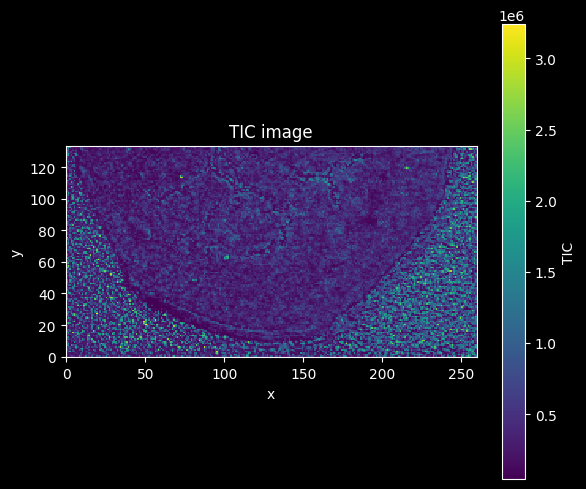

In [6]:
x = adata.obs["x"].to_numpy().astype(int)
y = adata.obs["y"].to_numpy().astype(int)
x0, y0 = x.min(), y.min()
grid_shape = (y.max() - y0 + 1, x.max() - x0 + 1)

tic_grid = np.full(grid_shape, np.nan, dtype=float)
tic_values = np.asarray(adata.X.sum(axis=1)).ravel()
for xi, yi, v in zip(x, y, tic_values, strict=False):
    tic_grid[yi - y0, xi - x0] = float(v)

plt.figure(figsize=(6, 5))
im = plt.imshow(tic_grid, origin="lower", interpolation="nearest")
plt.title("TIC image")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(im, label="TIC")
plt.tight_layout()
plt.show()

In [13]:
test = adata.var